In [ ]:
import numpy as np
from numpy.fft import fftshift, ifftshift, fftn, ifftn

def transform_kspace_to_image(k, dim=None, img_shape=None):
    """ Computes the Fourier transform from k-space to image space
    along a given or all dimensions

    :param k: k-space data
    :param dim: vector of dimensions to transform
    :param img_shape: desired shape of output image
    :returns: data in image space (along transformed dimensions)
    """
    if not dim:
        dim = range(k.ndim)

    img = fftshift(ifftn(ifftshift(k, axes=dim), s=img_shape, axes=dim), axes=dim)
    img *= np.sqrt(np.prod(np.take(img.shape, dim)))
    return img



def transform_image_to_kspace(img, dim=None, k_shape=None):
    """ Computes the Fourier transform from image space to k-space space
    along a given or all dimensions

    :param img: image space data
    :param dim: vector of dimensions to transform
    :param k_shape: desired shape of output k-space data
    :returns: data in k-space (along transformed dimensions)
    """
    if not dim:
        dim = range(img.ndim)

    k = fftshift(fftn(ifftshift(img, axes=dim), s=k_shape, axes=dim), axes=dim)
    k /= np.sqrt(np.prod(np.take(img.shape, dim)))
    return k


In [2]:
import os, glob, sys, io
from pprint import pprint
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
# import matplotlib as mpl
import scipy
import scipy.signal
import scipy.interpolate

import ismrmrd
import ismrmrdtools

In [4]:
data_dir = r'H:\Dataset\Bio\MRI Reconstruction\mridata'
tables = pd.read_csv('mridata.csv')
uuid = tables.iloc[0]['UUID']
filename = os.path.join(data_dir, uuid+".h5")
tables.iloc[[0]].T

,0
UUID,413469fd-9354-400c-88e3-b29e7c711a05
Downloads,2153
References,"Hammernik K, Klatzer T, Kobler E, Recht M, Sod..."
Comments,This is part of the training and test data tha...
Funding Support,NIH P41 EB017183
Protocol Name,SAG
Series Description,SAG
System Vendor,SIEMENS
System Model,Skyra
System Field Strength,2.89362 T


In [7]:

# Load file
if not os.path.isfile(filename):
    print("%s is not a valid file" % filename)
    raise SystemExit
dset = ismrmrd.Dataset(filename, 'dataset', create_if_needed=False)

header = ismrmrd.xsd.CreateFromDocument(dset.read_xml_header())
enc = header.encoding[0]

# Matrix size
eNx = enc.encodedSpace.matrixSize.x
eNy = enc.encodedSpace.matrixSize.y
eNz = enc.encodedSpace.matrixSize.z
rNx = enc.reconSpace.matrixSize.x
rNy = enc.reconSpace.matrixSize.y
rNz = enc.reconSpace.matrixSize.z

# Field of View
eFOVx = enc.encodedSpace.fieldOfView_mm.x
eFOVy = enc.encodedSpace.fieldOfView_mm.y
eFOVz = enc.encodedSpace.fieldOfView_mm.z
rFOVx = enc.reconSpace.fieldOfView_mm.x
rFOVy = enc.reconSpace.fieldOfView_mm.y
rFOVz = enc.reconSpace.fieldOfView_mm.z

lNx = rNx
lNy = enc.encodingLimits.kspace_encoding_step_1.maximum + 1
lNz = enc.encodingLimits.kspace_encoding_step_2.maximum + 1

# Number of Slices, Reps, Contrasts, etc.
ncoils = header.acquisitionSystemInformation.receiverChannels
if enc.encodingLimits.slice != None:
    nslices = enc.encodingLimits.slice.maximum + 1
else:
    nslices = 1


if enc.encodingLimits.repetition != None:
    nreps = enc.encodingLimits.repetition.maximum + 1
else:
    nreps = 1

if enc.encodingLimits.contrast != None:
    ncontrasts = enc.encodingLimits.contrast.maximum + 1
else:
    ncontrasts = 1

In [8]:

# TODO loop through the acquisitions looking for noise scans
firstacq=0
for acqnum in range(dset.number_of_acquisitions()):
    acq = dset.read_acquisition(acqnum)
    
    # TODO: Currently ignoring noise scans
    if acq.isFlagSet(ismrmrd.ACQ_IS_NOISE_MEASUREMENT):
        print("Found noise scan at acq ", acqnum)
        continue
    else:
        firstacq = acqnum
        print("Imaging acquisition starts acq ", acqnum)
        break


Imaging acquisition starts acq  0


In [17]:
import numpy as np

def transform_kspace_to_image(k, dim=None, img_shape=None):
    """ Computes the Fourier transform from k-space to image space
    along a given or all dimensions

    :param k: k-space data
    :param dim: vector of dimensions to transform
    :param img_shape: desired shape of output image
    :returns: data in image space (along transformed dimensions)
    """
    if not dim:
        dim = range(k.ndim)

    img = np.fft.fftshift(scipy.fft.ifftn(np.fft.ifftshift(k, axes=dim), s=img_shape, axes=dim, 
                                          workers=os.cpu_count()), axes=dim)
    return img



def transform_image_to_kspace(img, dim=None, k_shape=None):
    """ Computes the Fourier transform from image space to k-space space
    along a given or all dimensions

    :param img: image space data
    :param dim: vector of dimensions to transform
    :param k_shape: desired shape of output k-space data
    :returns: data in k-space (along transformed dimensions)
    """
    if not dim:
        dim = range(img.ndim)

    k = np.fft.fftshift(scipy.fft.fftn(np.fft.ifftshift(img, axes=dim), s=k_shape, axes=dim, 
                                       workers=os.cpu_count()), axes=dim)
    return k


In [18]:
%%time 
import os
import ismrmrd
import ismrmrd.xsd
import numpy as np

from ismrmrdtools import show, transform


remove_oversampling_x = True

# Initialiaze a storage array
all_data = np.zeros((nreps, ncontrasts, nslices, ncoils, lNz, lNy, rNx if remove_oversampling_x else eNx), 
                    dtype=np.complex64)

# Loop through the rest of the acquisitions and stuff
for acqnum in range(firstacq,dset.number_of_acquisitions()):
    acq = dset.read_acquisition(acqnum)

    # TODO: this is where we would apply noise pre-whitening

    # Remove oversampling if needed
    if remove_oversampling_x and eNx != rNx:
        xline = transform_kspace_to_image(acq.data, [1])
        x0 = (eNx - rNx) // 2
        x1 = (eNx - rNx) // 2 + rNx
        xline = xline[:,x0:x1]
        acq.resize(rNx,acq.active_channels,acq.trajectory_dimensions)
        acq.center_sample = rNx//2
        # need to use the [:] notation here to fill the data
        acq.data[:] = transform_image_to_kspace(xline, [1])
  
    # Stuff into the buffer
    rep = acq.idx.repetition
    contrast = acq.idx.contrast
    slice = acq.idx.slice
    y = acq.idx.kspace_encode_step_1
    z = acq.idx.kspace_encode_step_2
    all_data[rep, contrast, slice, :, z, y, :] = acq.data

Wall time: 2min 39s


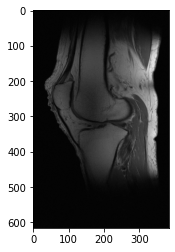

Wall time: 5.73 s


In [19]:
%%time 
data_orig = np.squeeze(all_data)
im = np.fft.fftshift(scipy.fft.fft2(data_orig, workers=os.cpu_count()))
im = np.sqrt(np.sum(im**2,1))
plt.imshow(np.abs(im[5]), cmap='gray')
plt.show()